# Naive Bayes Classifier 

###  <div align=center> Moon Il-chul(icmoon@kaist.ac.kr); Shin Dong-hyeok(tlsehdgur0@kaist.ac.kr) </div>

본 코드는 Naive Bayes Classifier의 구현 예시입니다.  
본 코드는 여러개의 문서 속 단어들을 통해 각 문서의 sentiment를 확률적으로 classification하고, 이 결과값을 각 문서의 실제 sentiment와 비교하여 정확도를 측정합니다.   
본 코드를 통하여, 간단하고도 효율적인 Naive Bayes Classifier의 이론과 구현 과정을 익힐 수 있습니다.

### 데이터 입력 및 전처리 과정 

주어진 sentimentdataset.mat 파일에는 3종류의 matlab 변수가 저장되어 있습니다.

* bagofword : 198 X 29717 numpy ndarray, 198개의 문서에서 29717개의 단어에 대한 bag of word 저장
* sentiment : 198 X 1 numpy ndarray, 198개의 문서에 대한 positive sentiment/negative sentiment를 각각 0과 1로 저장
* words : 29717 X 1 numpy ndarray, 29717개의 unique 단어 저장 


### 실제 구현부

Naive Bayes Classifier는 Bayes Theorem과 Conditional independent assumption을 이용하여 classification을 수행하는 모델입니다.
Naive Bayes Classifier function은 아래와 같이 표현합니다.
$$f_{NB} (x)=argmax_{Y=y} P(Y=y)\prod_{i=1}^d P(X_i=x_i \mid Y=y)$$

본 코드에서는 Naive Bayes Classfier fucntion을 구하기 위해 단계적으로 확률을 구합니다.

실제 구현에서 필요한 각 확률을 구할 때, 주어진 데이터로부터 cntXbyY, cntY를 이용하여 계산하였습니다.

* probsXbyY : numword X 2 numpy ndarray, 각 i번째 행은 likelihood $P(X_i=x_i \mid Y=y)$을 의미 
    $$P(X_i=x_i \mid Y=y_j) = \frac{cntXbyY[i,j]+\alpha-1}{cntY[j]+\alpha+\beta-2} ... (prbsXbyY에 대한 MAP 추론 참조)$$
* probsY : 2 X 1 numpy ndarray, class prior $P(Y=y)$를 의미 
    $$P(Y=y_j)=\frac{cntY}{\sum_{j}{cntY[j]}}$$
* probsSentiment : 198 X 2 numpy ndarray, 각 행은 문서가 0 또는 1을 가질 확률을 나타냄, $P(Y=y)\prod_{i=1}^d P(X_i=x_i \mid Y=y)$

#### probsXbyY에 대한 MAP 추론

실제 구현 과정에서 $P(X_i=x_i \mid Y=y_j)$를 구할 때 고려해 주어야하는 사항이 있습니다.   

만약 cntXbyY[i,j]가 0일 경우, MLE를 이용하면 $P(X_i=x_i \mid Y=y_j)= \frac{cntXbyY[i,j]}{cntY[j]}$로 해당 값이 0이 됩니다.   
이로 인해 추후 likelihood를 모두 곱하는 과정에서 다른 likelihood의 값과 관계없이 0이 되는 Numerical error가 발생하게 됩니다.

위와 같은 문제가 발생하는 이유는 $P(X_i=x_i \mid Y=y_j)$가 0이 될 수 있다는 강한 가정이 존재하기 때문입니다.   
따라서, 우리는 $p=P(X_i=positive \mid Y=y_j)$에 적절한 가정으로 prior를 부여함으로써 이러한 문제점을 해결할 수 있습니다. 

현재 Random Variable $X_i=x_i \mid Y=y_j$은 Bernoulli distribution with p을 가지므로, 
$P(X=x \mid Y=y)=\prod_{i=1}^d P(X_i=x_i \mid Y=y)$은 Binomial distribution with n, p을 가지게 됩니다.  
이때, $p=P(X_i=1 \mid Y=y)$는 Beta distribution with $\alpha=2, \beta=2$를 따르는 Random Variable로 가정합니다.  

위의 결과를 바탕으로 MAP로 구한 $\hat{p}$의 값은 아래와 같습니다.
$$\hat{p}=P(X_i=x_i \mid Y=y_j) = \frac{cntXbyY[i,j]+\alpha-1}{cntY[j]+\alpha+\beta-2}$$


In [5]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Shin Dong-hyeok: tlsehdgur0@kaist.ac.kr
'''

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from math import log  
%matplotlib inline  

In [6]:
data = sio.loadmat('sentimentdataset.mat', chars_as_strings=1, matlab_compatible=1)  

bagofword = data['bagofword'];  
sentiment = data['sentiment'];  
sentiment = sentiment.astype(int);
words = data['word'];

# 낱개로 떨어져있는 단어를 하나의 온전한 단어로 합쳐주는 과정
# ex) [['h', 'o', 'l', 'e', 's']]  -> 'holes'
word = []  
for n in range(2000):
    word = word + [str(''.join(letter)) for letter in words[n][0]]

In [11]:
cell = 10;  # Training set의 크기를 변화시키는 횟수
replication = 2; # 반복횟수
numTesting = 50; # Testing set의 크기
numWord = 2000;
alpha = 2.0 # Beta Distribution의 parameter
beta = 2.0 # Beta Distribution의 parameter

trainingAccuracy = np.zeros((replication, 10));
testingAccuracy = np.zeros((replication,10));
avgTraining = np.zeros((cell,1));
stdTraining = np.zeros((cell,1));
avgTesting = np.zeros((cell,1));
stdTesting = np.zeros((cell,1));


for M in range(1,cell+1): # Training set의 변화 횟수만큼 반복  
    N = M * 10;  # N : Training set의 갯수
    for rep in range(replication):  
        sample = np.random.permutation(np.arange(198))
        
        # 데이터에 랜덤성 부여
        X = bagofword[sample]; 
        Y = sentiment[sample];
        
        cntXbyY = np.zeros((numWord,2))
        for i in range(numWord): 
            for j in range(N): 
                if X[j,i] >= 1: # j번째 문서에 i번째 단어가 있을 경우
                    cntXbyY[i,Y[j]] = cntXbyY[i,Y[j]] + 1; # j번째 문서의 실제 sentiment에 +1을 해준다  
        
        # cntY : Training set에 Positive sentiment와 Negative sentiment의 갯수 
        cntY = np.zeros((2,1)); 
        for j in range(N): # Training set만큼 counting 
            if Y[j] == 0: 
                cntY[0] = cntY[0] + 1; 
            else:
                cntY[1] = cntY[1] + 1;
        
        # probsXbyY : Sentiment가 주어질 때, 각 단어가 해당 Sentiment를 가질 확률
        # 해당 단어가 등장하는 Positive(또는 Negative) Sentiment 문서의 갯수 / Positive(또는 Negative) Sentiment의 갯수
        probsXbyY = np.zeros((numWord, 2));
        for i in range(numWord):
            for j in range(2):
                probsXbyY[i,j] = (cntXbyY[i,j]+alpha-1) / float(cntY[j]+alpha+beta-2);
                
     
        # probsY : 어떤 문서가 Positive 또는 Negative Sentiment를 가질 확률
        # Positive(또는 Negative) Sentiment인 문서 갯수 / 전체 문서 갯수
        probsY = np.zeros((2,1));
        for j in range(2):
            probsY[j] = cntY[j] / float(cntY[0]+cntY[1])
            
        logProbsSentiment = np.zeros((198,2));
        for i in range(198):
            for k in range(2):
                logProbsSentiment[i,k] = 0;
                for j in range(numWord):
                    if X[i,j] == 1:
                        logProbsSentiment[i,k] = logProbsSentiment[i,k] + log(probsXbyY[j,k]);
                    else:
                        logProbsSentiment[i,k] = logProbsSentiment[i,k] + log(1 - probsXbyY[j,k]);
                logProbsSentiment[i,k] = logProbsSentiment[i,k] + log(probsY[k,0]);
        
        # 각 문서에 대하여 Sentiment 값을 추정하여 결정  
        estSentiment = np.zeros((198,1)); 
        for i in range(198): # 전체 문서수(198개)만큼 반복 실행
            if logProbsSentiment[i,0] > logProbsSentiment[i,1]: # i번째 문서의 probsSentiment가 0일 확률이 1일 확률보다 클 경우 
                estSentiment[i] = 0;
            else:
                estSentiment[i] = 1;
                
        # Training set에 대하여 각각의 실제 Sentiment 값과 비교하여 정확도 계산
        cntCorrect = 0; 
        for i in range(N): # N(Training set 갯수)만큼 반복 실행
            if estSentiment[i] == Y[i]:
                cntCorrect = cntCorrect + 1;
        trainingAccuracy[rep,M-1] = cntCorrect / float(N);
        
        # Testing set에 대하여 각각의 실제 Sentiment 값과 비교하여 정확도 계산
        cntCorrect = 0; 
        for i  in range(N,N+numTesting+1):  # N개 이후의 numTesting 갯수만큼 반복 실행
            if estSentiment[i] == Y[i]:
                cntCorrect = cntCorrect + 1;
        testingAccuracy[rep,M-1] = cntCorrect / float(numTesting);
    
    # 정확도의 평균값 계산
    avgTraining[M-1] = np.mean(trainingAccuracy[:,M-1]);
    avgTesting[M-1] = np.mean(testingAccuracy[:,M-1]);
    # 정확도의 표준편차 계산
    stdTraining[M-1] = np.std(trainingAccuracy[:,M-1]);
    stdTesting[M-1] = np.std(testingAccuracy[:,M-1]);

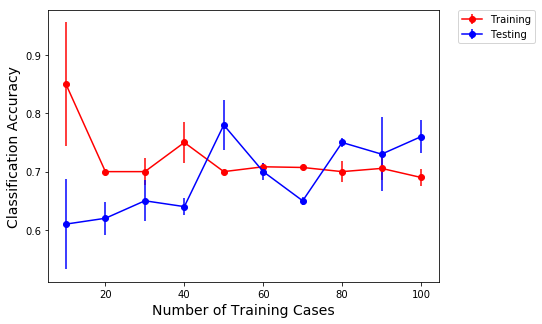

In [12]:
plt.figure(1, figsize=(7,5))
plt.errorbar(np.dot(10,range(1,cell+1)),avgTraining,yerr = stdTraining/np.sqrt(replication), fmt='-o', color='r', label = "Training");
plt.errorbar(np.dot(10,range(1,cell+1)),avgTesting,yerr = stdTesting/np.sqrt(replication),  fmt='-o', color='b', label = "Testing");

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Number of Training Cases', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)

plt.show();

### 결과 해석부

위의 그래프는 Training set의 크기를 변화시키며 Naive Bayes Classifier를 통해 classification을 한 후 각 문서의 실제 sentiment와 비교하여 정확도를 측정한 결과입니다.  

이러한 결과를 바탕으로, Naive Bayes Classifier가 주어진 데이터를 어떻게 classification하는지 알 수 있습니다. 
